In [ ]:
# Mounting Google Drive and Set Up
from google.colab import drive
import sys

drive.mount('/content/drive')
%cd /content/drive/MyDrive/Backend_old
sys.path.append('/content/drive/MyDrive/Backend_old')

Mounted at /content/drive
/content/drive/MyDrive/Backend_old


In [ ]:
# Import libraries
import json
import pickle
import torch
import random
import itertools
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
import seaborn as sns
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
# Import custom modules
from nltk_utils import tokenize, stem, build_vocab, sentence_to_indices
from nnet import NeuralNet

#Building the Symptom Extraction Model (Multi-label Classification)

In [ ]:
# Load dataset
with open("multi_label_dataset.json", "r") as f:
    data = json.load(f)

In [ ]:
# Prepare tag mappings
all_tags = sorted(set(tag for item in data for tag in item['tags']))
tag2idx = {tag: idx for idx, tag in enumerate(all_tags)}

In [ ]:
# Build vocabulary
all_sentences = [item["sentence"] for item in data]
vocab, word2idx = build_vocab(all_sentences)

In [ ]:
# Fixed Hyperparameters
max_len = 10
output_size = len(all_tags)
vocab_size = len(word2idx)
batch_size = 8
num_epochs = 20

# Hyperparameter search space
hidden_sizes = [32, 64, 128]
learning_rates = [0.001, 0.0005]
embed_sizes = [32, 64]

In [ ]:
# Prepare training data
X_all, y_all = [], []
for item in data:
    indices = sentence_to_indices(item["sentence"], word2idx, max_len)
    label_vector = [0] * output_size
    for tag in item["tags"]:
        label_vector[tag2idx[tag]] = 1
    X_all.append(indices)
    y_all.append(label_vector)

X_all = torch.tensor(X_all, dtype=torch.long)
y_all = torch.tensor(y_all, dtype=torch.float32)

<ipython-input-8-19dd2556b09b>:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  X_all = torch.tensor(X_all, dtype=torch.long)


In [ ]:
# Split into train and validation
dataset = torch.utils.data.TensorDataset(X_all, y_all)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [ ]:
# Model setup
model = NeuralNet(vocab_size, embed_size, hidden_size, output_size, max_len)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Track best model
best_val_loss = float('inf')
best_hyperparams = None

In [ ]:
# Random search setup
n_trials = 5
best_val_loss = float('inf')
best_hyperparams = None

for trial in range(n_trials):
    # Randomly pick one of each
    hidden_size = random.choice(hidden_sizes)
    learning_rate = random.choice(learning_rates)
    embed_size = random.choice(embed_sizes)

    print(f"Trial {trial+1}/{n_trials}: hidden_size={hidden_size}, learning_rate={learning_rate}, embed_size={embed_size}")

    # Model setup
    model = NeuralNet(vocab_size, embed_size, hidden_size, output_size, max_len)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses, val_losses = [], []

    # Train normally for num_epochs
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        for words, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(words)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for words, labels in val_loader:
                outputs = model(words)
                val_loss += criterion(outputs, labels).item()
        val_losses.append(val_loss / len(val_loader))
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    final_val_loss = val_losses[-1]
    print(f"Final Validation Loss: {final_val_loss:.4f}")

    # Save best model
    if final_val_loss < best_val_loss:
        best_val_loss = final_val_loss
        best_hyperparams = {
            "hidden_size": hidden_size,
            "learning_rate": learning_rate,
            "embed_size": embed_size
        }
        model_data = {
            "model_state": model.state_dict(),
            "input_size": max_len,
            "hidden_size": hidden_size,
            "output_size": output_size,
            "vocab_size": vocab_size,
            "tags": all_tags,
            "word2idx": word2idx,
            "embed_size": embed_size
        }
        torch.save(model_data, "models/best_multi_label_model.pth")
        with open("models/best_multi_word2idx.pkl", "wb") as f:
            pickle.dump(word2idx, f)

print("\nBest Validation Loss:", best_val_loss)
print("Best Hyperparameters:", best_hyperparams)

Trial 1/5: hidden_size=128, learning_rate=0.0005, embed_size=64
Epoch [1/20], Train Loss: 0.1940, Val Loss: 0.1107
Epoch [2/20], Train Loss: 0.1021, Val Loss: 0.0995
Epoch [3/20], Train Loss: 0.0951, Val Loss: 0.0959
Epoch [4/20], Train Loss: 0.0906, Val Loss: 0.0922
Epoch [5/20], Train Loss: 0.0863, Val Loss: 0.0882
Epoch [6/20], Train Loss: 0.0815, Val Loss: 0.0839
Epoch [7/20], Train Loss: 0.0768, Val Loss: 0.0797
Epoch [8/20], Train Loss: 0.0723, Val Loss: 0.0762
Epoch [9/20], Train Loss: 0.0685, Val Loss: 0.0733
Epoch [10/20], Train Loss: 0.0650, Val Loss: 0.0710
Epoch [11/20], Train Loss: 0.0622, Val Loss: 0.0693
Epoch [12/20], Train Loss: 0.0599, Val Loss: 0.0680
Epoch [13/20], Train Loss: 0.0578, Val Loss: 0.0669
Epoch [14/20], Train Loss: 0.0560, Val Loss: 0.0660
Epoch [15/20], Train Loss: 0.0543, Val Loss: 0.0650
Epoch [16/20], Train Loss: 0.0528, Val Loss: 0.0643
Epoch [17/20], Train Loss: 0.0514, Val Loss: 0.0637
Epoch [18/20], Train Loss: 0.0500, Val Loss: 0.0632
Epoch [19

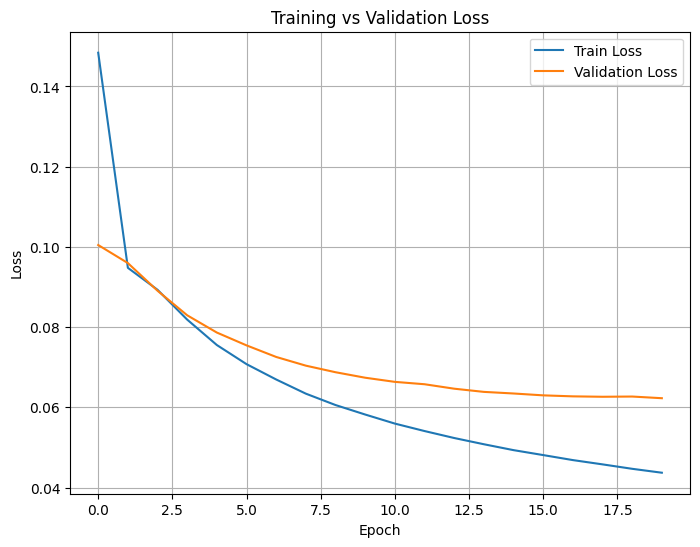

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# **Build Disease Prediction Model (Stacked Ensemble)**

In [ ]:
# Load disease dataset
df = pd.read_csv("Training.csv")
df.drop(columns=[col for col in df.columns if 'Unnamed' in col], inplace=True)

X = df.drop("prognosis", axis=1).astype(int)
y = df["prognosis"]

In [ ]:
# Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [ ]:
# Save mappings
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)
with open("list_of_symptoms.pickle", "wb") as f:
    pickle.dump(X.columns.tolist(), f)

In [ ]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

In [ ]:
# Cross-validation function
def cross_validation(X_train, y_train, model_name, parameter_range=15):
    train_errors, test_errors = [], []
    parameters = np.arange(1, parameter_range + 1)

    for parameter in parameters:
        if model_name == 'knn':
            model = KNeighborsClassifier(n_neighbors=parameter)
        elif model_name == 'logreg':
            model = LogisticRegression(solver='liblinear', C=1/(parameter*10))
        elif model_name == 'dctree':
            model = DecisionTreeClassifier(splitter='random', max_depth=parameter)
        elif model_name == 'svm':
            model = SVC(C=1/(parameter*5))

        model.fit(X_train, y_train)
        train_errors.append(1 - model.score(X_train, y_train))
        test_errors.append(1 - model.score(X_test, y_test))

    return parameters, train_errors, test_errors

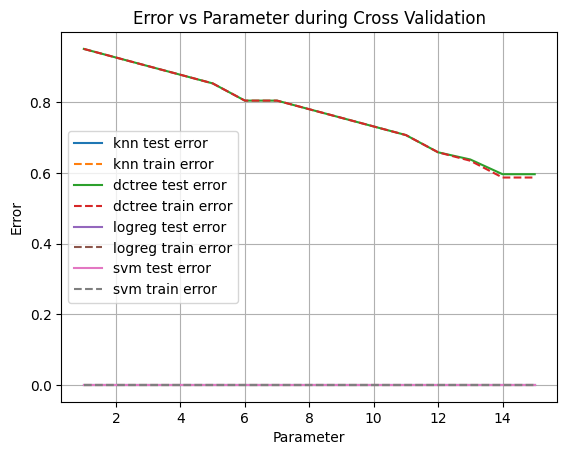

In [ ]:
# Find best hyperparameters
best_params = {}
model_names = ['knn', 'dctree', 'logreg', 'svm']
for model_name in model_names:
    parameters, train_errors, test_errors = cross_validation(X_train, y_train, model_name)
    plt.plot(parameters, test_errors, label=f"{model_name} test error")
    plt.plot(parameters, train_errors, linestyle='--', label=f"{model_name} train error")
    if model_name == 'logreg':
        best_params[model_name] = 1/(parameters[np.argmin(test_errors)]*10)
    elif model_name == 'svm':
        best_params[model_name] = 1/(parameters[np.argmin(test_errors)]*5)
    else:
        best_params[model_name] = parameters[np.argmin(test_errors)]

plt.xlabel('Parameter')
plt.ylabel('Error')
plt.title('Error vs Parameter during Cross Validation')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Build stacking ensemble
base_models = [
    ('lr', LogisticRegression(solver='liblinear', C=best_params['logreg'])),
    ('knn', KNeighborsClassifier(n_neighbors=best_params['knn'])),
    ('dctree', DecisionTreeClassifier(splitter='random', max_depth=best_params['dctree'])),
    ('svm', SVC(C=best_params['svm'], probability=True))
]
ensemble = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression(), cv=5)

ensemble.fit(X_train, y_train)


StackingClassifier(cv=5,
                   estimators=[('lr',
                                LogisticRegression(C=np.float64(0.1),
                                                   solver='liblinear')),
                               ('knn',
                                KNeighborsClassifier(n_neighbors=np.int64(1))),
                               ('dctree',
                                DecisionTreeClassifier(max_depth=np.int64(14),
                                                       splitter='random')),
                               ('svm',
                                SVC(C=np.float64(0.2), probability=True))],
                   final_estimator=LogisticRegression())

In [ ]:
# Evaluate Models
def evaluate_models():
    models = {
        'KNN': KNeighborsClassifier(n_neighbors=best_params['knn']),
        'Decision Tree': DecisionTreeClassifier(splitter='random', max_depth=best_params['dctree']),
        'Logistic Regression': LogisticRegression(solver='liblinear', C=best_params['logreg']),
        'SVM': SVC(C=best_params['svm'], probability=True)
    }
    results = {}
    for name, clf in models.items():
        clf.fit(X_train, y_train)
        train_acc = clf.score(X_train, y_train)
        test_acc = clf.score(X_test, y_test)
        results[name] = (train_acc, test_acc)
    results['Stacking Ensemble'] = (ensemble.score(X_train, y_train), ensemble.score(X_test, y_test))
    return results

results = evaluate_models()

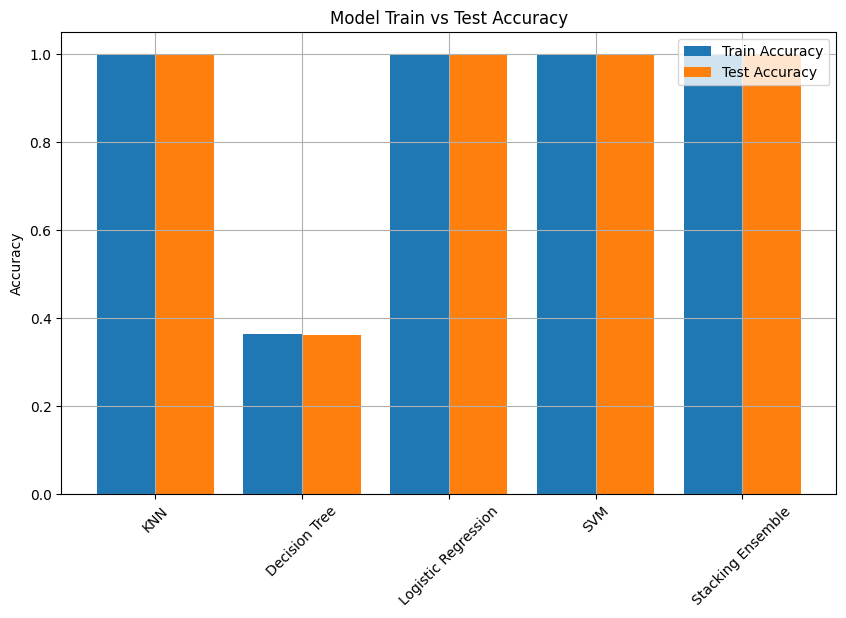

In [ ]:
# Plot accuracies
models = list(results.keys())
train_acc = [results[m][0] for m in models]
test_acc = [results[m][1] for m in models]

plt.figure(figsize=(10,6))
x = np.arange(len(models))
plt.bar(x-0.2, train_acc, width=0.4, label='Train Accuracy')
plt.bar(x+0.2, test_acc, width=0.4, label='Test Accuracy')
plt.xticks(x, models, rotation=45)
plt.ylabel('Accuracy')
plt.title('Model Train vs Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()

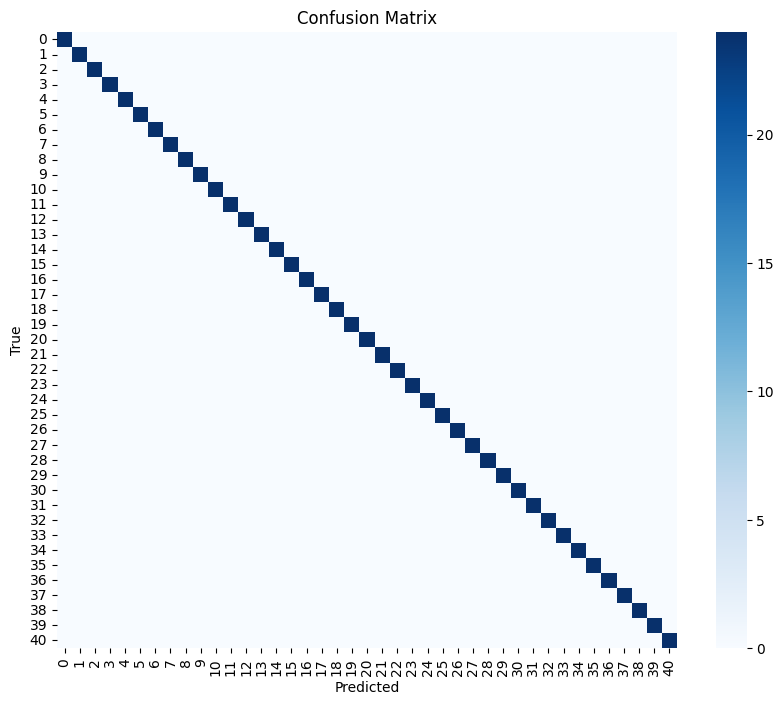

In [ ]:
# Confusion Matrix for Stacked Ensemble
y_pred = ensemble.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      1.00      1.00        24
           2       1.00      1.00      1.00        24
           3       1.00      1.00      1.00        24
           4       1.00      1.00      1.00        24
           5       1.00      1.00      1.00        24
           6       1.00      1.00      1.00        24
           7       1.00      1.00      1.00        24
           8       1.00      1.00      1.00        24
           9       1.00      1.00      1.00        24
          10       1.00      1.00      1.00        24
          11       1.00      1.00      1.00        24
          12       1.00      1.00      1.00        24
          13       1.00      1.00      1.00        24
          14       1.00      1.00      1.00        24
          15       1.00      1.00      1.00        24
          16       1.00      1.00      1.00        24
          17       1.00    

In [ ]:
# Save ensemble model
with open("fitted_model_stacked_final.pkl", "wb") as f:
    pickle.dump(ensemble, f)

print("\u2705 Full Pipeline Complete!")

✅ Full Pipeline Complete!


In [ ]:
### 3. Demo: Full Input -> Symptom Extraction -> Disease Prediction

def predict_pipeline(user_input):
    model.eval()
    tokens = tokenize(user_input)
    indices = sentence_to_indices(' '.join(tokens), word2idx, max_len)
    input_tensor = torch.tensor(indices, dtype=torch.long).unsqueeze(0)
    output = model(input_tensor)
    preds = torch.sigmoid(output).squeeze().detach().numpy()
    symptoms = [all_tags[idx] for idx, p in enumerate(preds) if p > 0.5]
    print(f"\nExtracted Symptoms: {symptoms}")

    feature_vector = [0] * len(X.columns)
    for symptom in symptoms:
        if symptom in X.columns:
            feature_vector[X.columns.tolist().index(symptom)] = 1

    prediction = ensemble.predict([feature_vector])[0]
    disease = le.inverse_transform([prediction])[0]
    print(f"Predicted Disease: {disease}\n")

# Example usage
predict_pipeline("I have been feeling very tired and my eyes are red.")
predict_pipeline("Cough and sneezing with body aches.")



Extracted Symptoms: ['sunken_eyes']
Predicted Disease: Gastroenteritis


Extracted Symptoms: ['continuous_sneezing']
Predicted Disease: Allergy



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages